In [1]:
import torch
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from itertools import product
from sklearn.metrics import precision_score, recall_score, adjusted_rand_score
if torch.cuda.is_available():
    !nvidia-smi
else:
    print("GPU is not availabel")

Sun Dec 24 18:01:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:73:00.0  On |                  N/A |
| 71%   70C    P2   349W / 350W |  12158MiB / 24260MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:D5:00.0 Off |                  N/A |
| 30%   

In [2]:
import Model as model

## Outlier Detection

In [3]:
ref = sc.read_h5ad("/volume1/home/kliu/Data/scdata/PBMC_12/PBMC1.h5ad")
adata = sc.read_h5ad("/volume1/home/kliu/Data/scdata/PBMC_12/PBMC2.h5ad")
ref = ref[ref.obs["cell.type"] != "B cells"]
ref.obs["cell.type"].value_counts()

cell.type
CD4 T cells          5783
CD14+ Monocytes      2055
CD8 T cells          1653
NK cells             1577
FCGR3A+ Monocytes     624
Dendritic cells       198
Megakaryocytes         60
Name: count, dtype: int64

In [4]:
result = model.outlier_detect(ref, adata)

Begin to learn information of normal cells with ODBC-GAN...


Information of normal cells have been learned.

Begin to detect outlier cell types with ODBC-GAN...
Outlier cell types have been detected.



In [5]:
adata.obs['score'] = result['score'].values
adata.obs['Pred'] = (adata.obs['score'] > 0.25).astype('category')
adata.obs['label'] = [1 if i == 'B cells' else 0 for i in adata.obs['cell.type']]

In [6]:
ps = precision_score(adata.obs['Pred'], adata.obs['label'])
ps

0.9939475453934096

In [7]:
rs = recall_score(adata.obs['Pred'], adata.obs['label'])
rs

0.1306115235065394

In [8]:
F1_score = 2 * rs * ps / (rs + ps)
F1_score

0.2308833867062407

## Batch Correction

### Alignment

In [9]:
ref = sc.read_h5ad("/volume1/home/kliu/Data/scdata/PBMC_12/PBMC1.h5ad")
adata1 = sc.read_h5ad("/volume1/home/kliu/Data/scdata/PBMC_12/PBMC2.h5ad")
adata = ad.concat([ref, adata1], merge="same", label="batch")
adata

/usr/local/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 27911 × 3000
    obs: 'cell.type', 'batch'

/usr/local/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/anaconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/anaconda3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

scanpy==1.9.6 anndata==0.10.3 umap==0.5.3 numpy==1.26.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.2.0 statsmodels==0.13.5 igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50


/usr/local/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


    finished (0:00:05)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


/usr/local/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/anaconda3/lib/pyt

[<AxesSubplot: title={'center': 'Raw'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'cell.type'}, xlabel='UMAP1', ylabel='UMAP2'>]

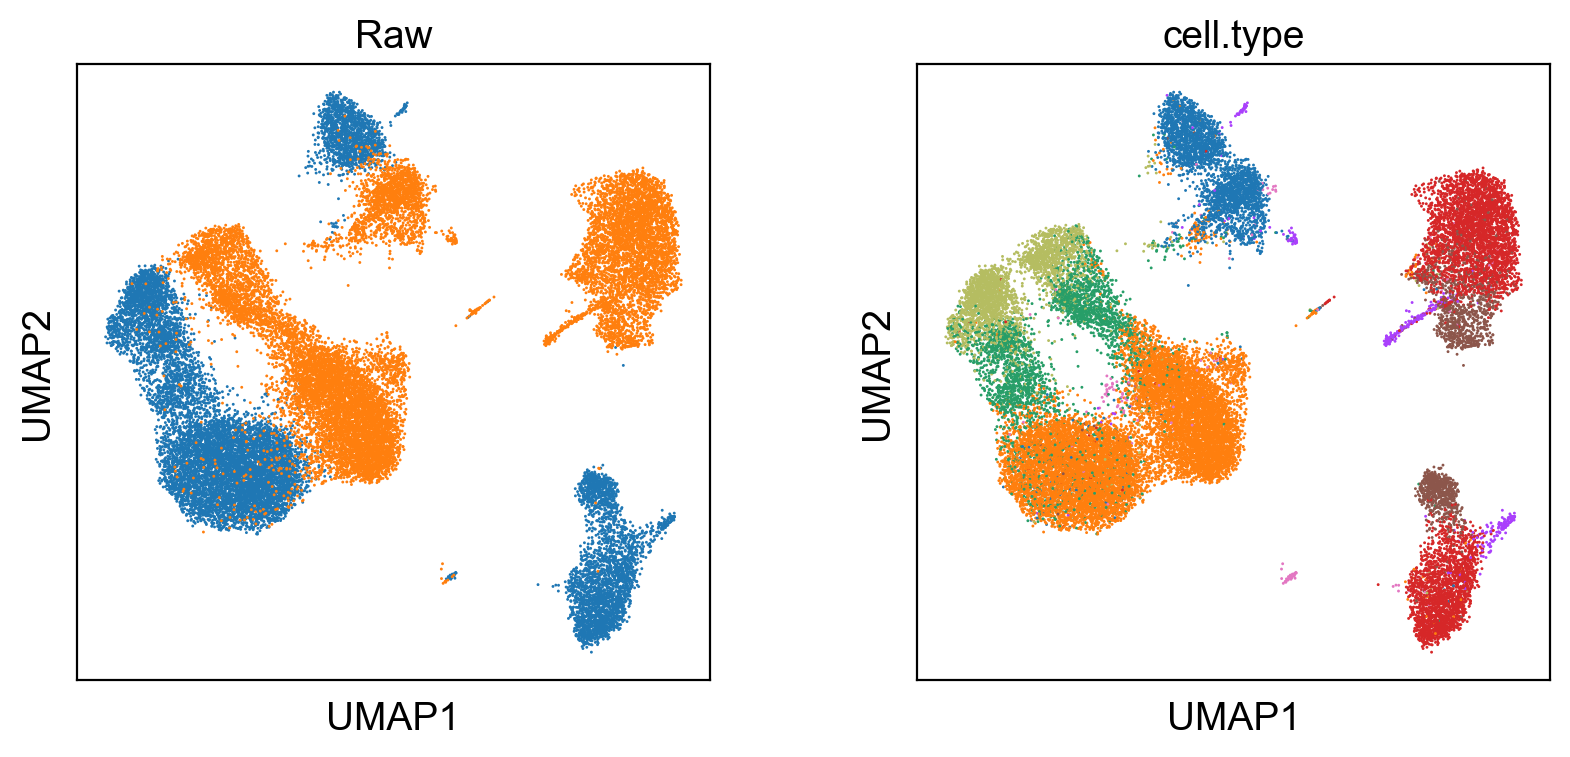

In [10]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, legend_fontsize=8, legend_loc=None, color=["batch", "cell.type"],\
           title="Raw", show=False)

In [11]:
result_align = model.obs_align(adata1, ref)

Begin to find pairs of cells among multiple datasets...
Train Epoch: [200 /1000(20 %)]    G_loss: 0.064163    D_loss: 0.004763
Train Epoch: [400 /1000(40 %)]    G_loss: 0.066494    D_loss: -0.000131
Train Epoch: [600 /1000(60 %)]    G_loss: 0.070007    D_loss: -0.000747
Train Epoch: [800 /1000(80 %)]    G_loss: 0.071112    D_loss: -0.000728
Train Epoch: [1000/1000(100%)]    G_loss: 0.070691    D_loss: -0.000732
Cells have been paired successfully.



In [12]:
result_align

,ref_idx,input_idx
0,AAACATACCACTCC-1,GGAATCTGCCCTAC-1
1,AAACATACCGCTAA-1,CATTTGACGTTGAC-1
2,AAACATACTAACGC-1,CCTTAATGTCCGAA-1
3,AAACATACTTATCC-1,TTCGAGGAGAGAGC-1
4,AAACCGTGTCGCAA-1,CGGGACTGCTTGTT-1
...,...,...
13380,TTTGACTGTGCCCT-1,ACCCTCGAATGTCG-1
13381,TTTGCATGAGCATC-1,GGCAATACTTCGTT-1
13382,TTTGCATGCATTGG-1,GTGTAGTGAGCCTA-1
13383,TTTGCATGTATCGG-1,TGTAATGACAGTCA-1


In [13]:
def evaluate(ref, adata1, result):
    type1 = adata1.obs.loc[result['input_idx'], 'cell.type']
    # type2 = adata2.obs.loc[result["input2_idx'], 'cell.type']
    type3 = ref.obs.loc[result['ref_idx'], 'cell.type']

    a, b = 0, 0
    n = len(type1)
    for i in range(n):
        if type1[i] == type3[i]:
            a += 1
        # if type2[i] == type3[i]:
        #     b += 1
    return (a+b)/(n)
evaluate(ref, adata1, result_align)

/tmp/ipykernel_701600/3630092538.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type1[i] == type3[i]:


0.7277549495704146

### Correction

In [14]:
corrected_adata = model.batch_correct(adata1, ref, idx = result_align)

Begin to find pairs of cells among multiple datasets...
Train Epoch: [200 /1000(20 %)]    G_loss: 0.064163    D_loss: 0.004763
Train Epoch: [400 /1000(40 %)]    G_loss: 0.066494    D_loss: -0.000131
Train Epoch: [600 /1000(60 %)]    G_loss: 0.070007    D_loss: -0.000747
Train Epoch: [800 /1000(80 %)]    G_loss: 0.071112    D_loss: -0.000728
Train Epoch: [1000/1000(100%)]    G_loss: 0.070691    D_loss: -0.000732
Cells have been paired successfully.

Begin to remove batch effects with ODBC-GAN...
Train Epoch: [200 /1000(20 %)]    G_loss: 0.811297    D_loss: -0.287335
Train Epoch: [400 /1000(40 %)]    G_loss: 0.973045    D_loss: -0.271066
Train Epoch: [600 /1000(60 %)]    G_loss: 0.979364    D_loss: -0.155526
Train Epoch: [800 /1000(80 %)]    G_loss: 0.512637    D_loss: -0.173109
Train Epoch: [1000/1000(100%)]    G_loss: 0.884933    D_loss: -0.246064
Batch effects have been removed.



scanpy==1.9.6 anndata==0.10.3 umap==0.5.3 numpy==1.26.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.2.0 statsmodels==0.13.5 igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


/usr/local/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/anaconda3/lib/pyt

[<AxesSubplot: title={'center': 'Model'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'cell.type'}, xlabel='UMAP1', ylabel='UMAP2'>]

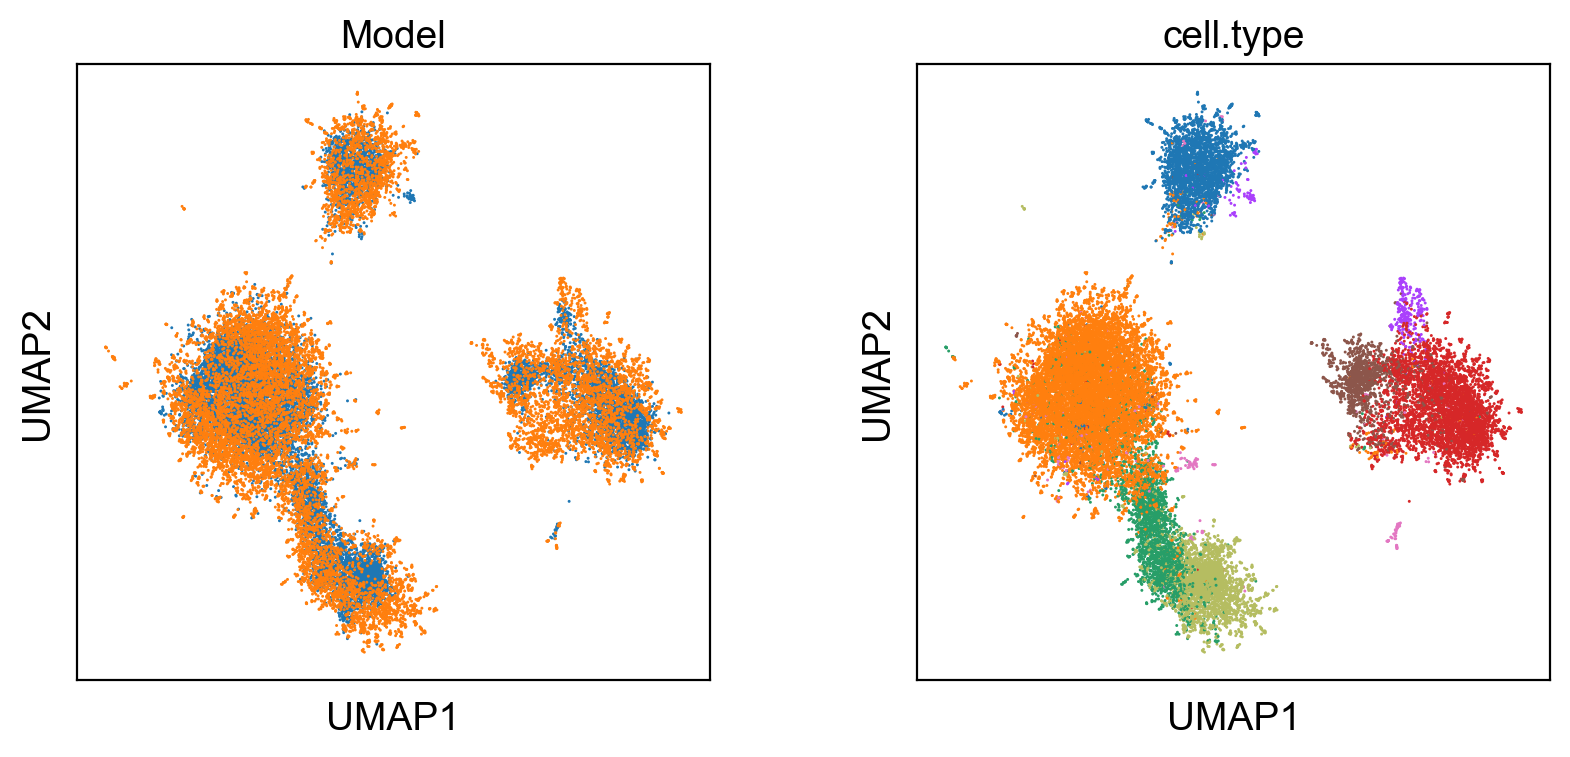

In [19]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, legend_fontsize=8, legend_loc=None, color=["batch", "cell.type"],\
           title="Model", show=False)

## Subtyping

In [17]:
ref = sc.read_h5ad("/volume1/home/kliu/Data/scdata/PBMC_12/PBMC1.h5ad")
adata = sc.read_h5ad("/volume1/home/kliu/Data/scdata/PBMC_12/PBMC2.h5ad")
ref = ref[ref.obs["cell.type"] != "B cells"]

In [ ]:
pred = model.subtype_detect(ref, adata, n_subtypes=3)
pred